# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [ ]:
import logging
import os

import random
import torchaudio
from pathlib import Path
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.appl

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []

        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data['label'].values)))}
            self._idx_to_label = {idx: key for key, idx in labels.items()}
            self._classes = len(labels)
        else:
            self._classes = None

        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        waveform = waveform.to(DEVICE)
        feats = self._feats(waveform)[0]
        return feats, self._labels[index]

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        if self._classes is None:
            raise ValueError("This dataset does not contain labels.")
        return self._classes

def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [ ]:
class LogMelSpectrogram(nn.Module):
    def __init__(self, n_mels=40, sample_rate=16000, n_fft=400, hop_length=160, f_min=0.0, f_max=None):
        super(LogMelSpectrogram, self).__init__()
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max if f_max else sample_rate // 2
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

    def forward(self, waveform):
        mel_spec = self.mel_spec(waveform)
        log_mel_spec = self.amplitude_to_db(mel_spec)
        return log_mel_spec

# FBANK 40 by default, but you can choose something else
FEATS = 40
transform = LogMelSpectrogram(n_mels=FEATS).to(DEVICE)
trainset = Dataset('train', 'ml_trains_data', transform, read_labels=True)
testset = Dataset('eval', 'ml_trains_data', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

Augmentation

In [ ]:
import random
from pathlib import Path
import pandas as pd
import torchaudio
import torchaudio.transforms as T
import torch

# Добавление шума
def add_noise(augmented_waveform, noise_level=0.001):
    noise = torch.randn_like(augmented_waveform) * noise_level
    return augmented_waveform + noise

# Сдвиг аудиосигнала
def shift_waveform(waveform, shift_max=0.2):
    shift = int(shift_max * waveform.size(-1) * random.uniform(-1, 1))
    return torch.roll(waveform, shifts=shift, dims=-1)

# Не используем pitch_shift(), потому что слишком много времени требуется на обработку данных
# # Изменение высоты тона
# def pitch_shift(waveform, sample_rate, n_steps=2):
#     n_steps_random = random.uniform(-n_steps, n_steps)
#     pitch_shift_transform = T.PitchShift(sample_rate=sample_rate, n_steps=n_steps_random)
#     return pitch_shift_transform(waveform)

# Обрезка аудиофайла
def random_crop(waveform, crop_fraction=0.1):
    length = waveform.size(-1)
    crop_size = int(length * crop_fraction)
    crop_start = random.randint(0, crop_size)
    crop_end = length - random.randint(0, crop_size)
    return waveform[..., crop_start:crop_end]

# Спектральные аугментации (SpecAugment)
def spec_augment(spectrogram):
    spectrogram = spectrogram.abs()  # Берем амплитуду (если данные комплексные)
    freq_mask = T.FrequencyMasking(freq_mask_param=30)
    time_mask = T.TimeMasking(time_mask_param=30)
    spectrogram = freq_mask(spectrogram)
    spectrogram = time_mask(spectrogram)
    return spectrogram

# Основная функция аугментации аудио
def augment_waveform(waveform, sample_rate):
    # STFT параметры
    n_fft = 1024
    hop_length = 256
    stft_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None)  # Комплексная спектрограмма
    complex_spec = stft_transform(waveform)

    # Time stretching
    rate = random.uniform(0.8, 1.2)
    time_stretch = T.TimeStretch(n_freq=n_fft // 2 + 1, fixed_rate=rate)
    stretched_spec = time_stretch(complex_spec)

    # SpecAugment (применяется только к амплитуде, без изменения комплексных данных)
    if random.random() < 0.5:
        magnitude = stretched_spec.abs()  # Амплитуда спектра
        phase = stretched_spec.angle()  # Фаза спектра
        magnitude = spec_augment(magnitude)  # Аугментация только амплитуды
        stretched_spec = torch.polar(magnitude, phase)  # Восстановление комплексного спектра

    # Inverse STFT
    istft_transform = T.InverseSpectrogram(n_fft=n_fft, hop_length=hop_length)
    augmented_waveform = istft_transform(stretched_spec)

    # Применяем другие аугментации
    if random.random() < 0.5:
        augmented_waveform = add_noise(augmented_waveform)

    if random.random() < 0.5:
        augmented_waveform = shift_waveform(augmented_waveform)

    # if random.random() < 0.5:
    #     augmented_waveform = pitch_shift(augmented_waveform, sample_rate)

    if random.random() < 0.5:
        augmented_waveform = random_crop(augmented_waveform)

    return torch.clamp(augmented_waveform, min=-1.0, max=1.0)

# Функция аугментации данных и обновления файла train.tsv
def augment_and_update_data(data, datadir, augment_percentage=0.2):
    augment_data = data.sample(frac=augment_percentage, random_state=42)
    new_ytids = []
    clips_dir = Path(datadir) / 'clips'

    for _, row in augment_data.iterrows():
        original_ytid = row['YTID']
        original_path = clips_dir / f"{original_ytid}.flac"

        if original_path.exists():
            # Загружаем оригинальный аудиофайл
            waveform, sample_rate = torchaudio.load(str(original_path))

            # Аугментируем аудиофайл
            augmented_waveform = augment_waveform(waveform, sample_rate)

            # Сохраняем аугментированный файл
            augmented_ytid = f"{original_ytid}_augmented"
            augmented_path = clips_dir / f"{augmented_ytid}.flac"
            torchaudio.save(str(augmented_path), augmented_waveform, sample_rate)

            # Добавляем запись о новом файле
            new_ytids.append({'YTID': augmented_ytid, 'label': row['label']})

    # Обновляем DataFrame с добавлением аугментированных данных
    augmented_df = pd.DataFrame(new_ytids)
    updated_train_data = pd.concat([data, augmented_df], ignore_index=True)

    # Сохраняем обновленный train.tsv
    updated_train_data.to_csv(Path(datadir) / 'train.tsv', sep='\t', index=False)
    return updated_train_data


### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [ ]:
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    class_accuracies = []
    for c in range(classes):
        tp = sum((y == c and p == c) for y, p in items)
        total = sum((y == c) for y, _ in items)
        if total == 0:
            continue
        class_accuracies.append(tp / total)
    return sum(class_accuracies) / len(class_accuracies)

In [ ]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [ ]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True,
    criterion: nn.Module = None
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        pred = model.forward(X)
        loss = criterion(pred.squeeze(), Y.squeeze())
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.cpu().data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)
def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
    criterion: nn.Module = None
):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)

    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size, criterion=criterion)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False, criterion=criterion)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()

        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')


In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_dim, 64, kernel_size=5, stride=1, padding=2), # Слой 1
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Пулинг для уменьшения размерности
            nn.Dropout(0.3),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1), # Слой 2
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1), # Слой 3
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), # Сжимаем до фиксированной длины
            nn.Dropout(0.3),

        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), # Полносвязный слой
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out_dim) # Классификация
        )

    def forward(self, X):
        x = self.conv_layers(X)
        return self.fc(x)

In [ ]:
train_data = pd.read_csv(os.path.join(DATADIR, 'train.tsv'), sep='\t')
train_data_updated = augment_and_update_data(train_data, DATADIR, augment_percentage=0.3)
trainset_updated = Dataset('train', DATADIR, transform, read_labels=True)

Распределение классов:
label
Speech                          2107
Music                           1980
Vehicle                         1447
Animal                          1357
Siren                           1274
Bird                            1198
Water                           1166
Engine                          1161
Tools                           1137
Crowd                           1119
Car passing by                  1115
Gunshot, gunfire                1108
Heavy engine (low frequency)    1085
Fireworks                       1058
Printer                         1054
Inside, small room              1048
Inside, large room or hall      1036
Female singing                  1025
Outside, urban or manmade       1014
Whack, thwack                   1011
Vacuum cleaner                  1005
Silence                         1002
Outside, rural or natural        982
Snoring                          977
Singing                          976
Sound effect                     964
Whistling

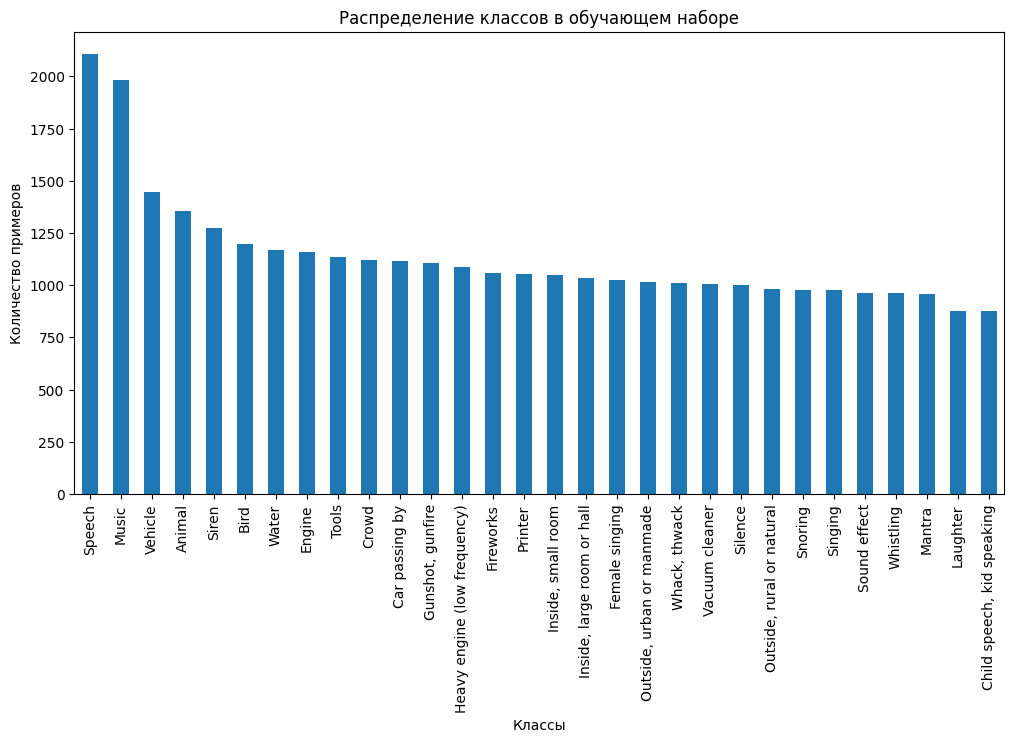

In [ ]:
train_data = pd.read_csv(os.path.join(DATADIR, 'train.tsv'), sep='\t')
class_counts = train_data['label'].value_counts()
print("Распределение классов:")
print(class_counts)

plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Распределение классов в обучающем наборе")
plt.xlabel("Классы")
plt.ylabel("Количество примеров")
plt.show()

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
print("Вес для каждого класса:", class_weights)
label_to_index = {label: idx for idx, label in enumerate(class_counts.index)}
weights = np.zeros(len(class_weights))
for label, weight in class_weights.items():
    weights[label_to_index[label]] = weight
weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights)


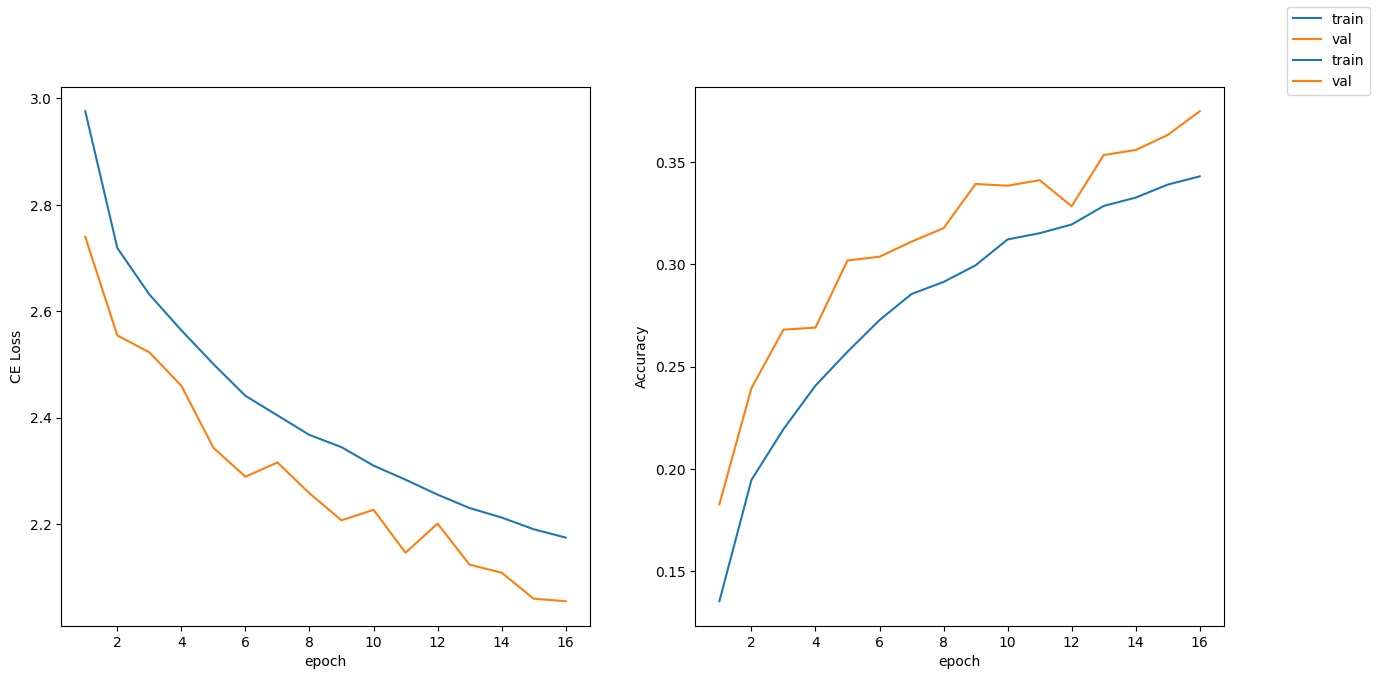

In [ ]:
model = Model().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train(model, opt, batch_size=64, epochs=40, criterion=criterion)

### Prediction part

Prepare result file and send it to Yandex.Contest

In [ ]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]
    feats = feats.to(DEVICE)
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

In [ ]:
from google.colab import files
files.download('result.tsv')